# EuroCrops Demo

This notebook assists with exploring the EuroCrops demo dataset.


### Imports

In [214]:
from dataclasses import dataclass
import datetime as dt
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import json
import random
import sklearn
from tqdm import tqdm
import copy

%matplotlib inline

In [245]:
from torch import nn
import torch

In [3]:
from joblib import Memory
location = os.path.abspath('./cachedir')
print(f'cache location: {location}')
memory = Memory(location, verbose=0)


cache location: /home/przemek/Projects/pp/eurocrops/notebooks/cachedir


### Load Data

In [4]:
ROOT_DATA_PATH = '/media/data/local/eurocrops/m1615987/'
H5_FILE_PATH = os.path.join(ROOT_DATA_PATH, 'HDF5s/train/AT_T33UWP_train.h5')

In [5]:
NUMBER_OF_CHANNELS = 13

In [6]:
def _load_data_from_h5_file(h5_file_path):
    hdf = pd.HDFStore(h5_file_path, mode='r') #here we directly load the .h5 file in one go using pandas.
    region_names = hdf.keys()  #list all the keys or regions in the region (for eg- AT112)
    region_names = region_names[:3]
    df_datas = []

    for region_name in tqdm(region_names):
        df_data_single = hdf.get(f'/{region_name}') #selecting a region from based on the key (AT112 for eg.)
        df_datas.append(df_data_single)
    
    #len(set.union(*[set(x.columns) for x in df_datas]))  120 columns now, but for one region there are only 80, intesection 44
    #len(set.intersection(*[set(x.columns) for x in df_datas]))  # 120 columns now, but for one region there are only 80
    
    return df_datas, region_names
        

def _is_column_in_row_inalid(rc):
    # all_zeros = not np.any(rc) - old version - all values 0
    # new version - 2 interesting values 0 (it happens sometimes that only one channel is not zero)
    return rc[4-1] == 0 and rc[8-1] == 0  
    
    
def _find_closest_non_zero_column(time_index, common_days, dates_list, row):
    # this time step is zero, we needto find another one that is not zero.
    # To do it, find all closest non-zero columns (for all time steps for this row) 
        
    time_distance_to_nonzero_columns = [abs(common_days[time_index] - v) for v in dates_list]
    for k in range(len(time_distance_to_nonzero_columns)):
        #if not np.any(row.iloc[k]):
        if _is_column_in_row_inalid(row.iloc[k]):
            time_distance_to_nonzero_columns[k] = 9999
    closest_nonzero_column = np.argmin(time_distance_to_nonzero_columns)
    return closest_nonzero_column

    
def _resample_and_concatenate_regions_data(df_datas, resampled_days_interval):
    # Conatenation of data with different dates - fixed interval span, with finding closes date (better to use interpolation, but not with nois cloud data)
    DI = resampled_days_interval  # days interval
    common_days = list(range(DI, 365, DI))
    print(f'len(common_days) = {len(common_days)}')
    # common_days_datetime = [for day in common_days]

    # year = int(timesteps[10][:4])
    # new_year_day = dt.datetime(year=year, month=1, day=1)
    # dates_list = [((dt.datetime.strptime(date, tf)- new_year_day).days + 1) for date in timesteps]

    df_data_all = pd.DataFrame(columns=common_days)


    for df_data_single in tqdm(df_datas):
        timesteps = list(df_data_single.columns)
        year = int(timesteps[10][:4])
        new_year_day = dt.datetime(year=year, month=1, day=1)
        tf = '%Y%m%d'
        dates_list = [((dt.datetime.strptime(date, tf)- new_year_day).days + 1) for date in timesteps]
        df_data_single = df_data_single.rename(columns={old: new for old, new in zip(timesteps, dates_list)})

        closest_columns = []
        for common_day in common_days:
            closest_column = np.argmin([abs(common_day - v) for v in dates_list])
            closest_columns.append(closest_column)

        new_frames = []
        for index, row in df_data_single.iterrows():
            resampled_row_data = []
            
            for i, closest_column in enumerate(closest_columns):
                rc = row.iloc[closest_column]
                invalid_rc = _is_column_in_row_inalid(rc)
                if invalid_rc:
                    closest_nonzero_column = _find_closest_non_zero_column(
                        time_index=i,
                        common_days=common_days,
                        dates_list=dates_list, 
                        row=row)
                    rc = row.iloc[closest_nonzero_column]
                
                resampled_row_data.append(rc)

            resampled_row_df = pd.DataFrame([resampled_row_data], columns=common_days, index=[index])
            new_frames.append(resampled_row_df)

        new_frames_df = pd.concat(new_frames)
        df_data_all = pd.concat([df_data_all, new_frames_df])
    
    return df_data_all, common_days


def _load_all_labels(region_names):
    df_labels_all_lists = []
    for region_name in region_names:
        region_name = region_name.strip('/')
        LABELS_CSV_FILE_PATH = os.path.join(ROOT_DATA_PATH, f'csv_labels/train/demo_eurocrops_{region_name}.csv')
        GEO_JSON_FILE_PATH = os.path.join(ROOT_DATA_PATH, f'GeoJSONs_regional_split/train/AT/demo_eurocrops_{region_name}.geojson')

        # csv_file_path = os.path.join(train_csv_dir, csv_file_name)
        df_labels = pd.read_csv(LABELS_CSV_FILE_PATH, index_col=0)
        df_labels_all_lists.append(df_labels)


    df_labels_all = pd.concat(df_labels_all_lists)
    return df_labels_all
    

@memory.cache
def load_all_data_from_file_resampled(
        h5_file_path: str, 
        resampled_days_interval: int,
        ):
    df_datas, region_names = _load_data_from_h5_file(h5_file_path=h5_file_path)
    df_data_all, common_days = _resample_and_concatenate_regions_data(df_datas=df_datas, resampled_days_interval=resampled_days_interval)
    
    df_labels_all = _load_all_labels(region_names=region_names)

    return df_data_all, df_labels_all, common_days, region_names

In [7]:
df_data_all, df_labels_all, common_days, region_names = load_all_data_from_file_resampled(
    h5_file_path=H5_FILE_PATH, 
    resampled_days_interval=7,
    )

100%|███████████████████████████████████████████████████████████████████████████| 3/3 [01:17<00:00, 25.93s/it]


len(common_days) = 52


100%|██████████████████████████████████████████████████████████████████████████| 3/3 [09:46<00:00, 195.50s/it]


In [8]:
df_data_all.head(3)

,7,14,21,28,35,42,49,56,63,70,...,301,308,315,322,329,336,343,350,357,364
463,"[3871, 3600, 2992, 3105, 3205, 3320, 3321, 348...","[1679, 1241, 845, 742, 805, 866, 945, 854, 399...","[6992, 6542, 5944, 6414, 6786, 6859, 6973, 674...","[1456, 1079, 767, 673, 737, 796, 851, 772, 472...","[1456, 1079, 767, 673, 737, 796, 851, 772, 472...","[1511, 1079, 694, 540, 541, 580, 586, 538, 302...","[1556, 1172, 916, 862, 934, 1056, 1137, 1059, ...","[1968, 1501, 1274, 1269, 1304, 1461, 1601, 142...","[3378, 3184, 2888, 2967, 3079, 3241, 3332, 332...","[1433, 1104, 870, 855, 967, 1139, 1245, 1185, ...",...,"[1598, 1252, 998, 944, 1000, 1137, 1244, 1190,...","[1449, 1115, 789, 666, 674, 724, 786, 740, 256...","[1449, 1115, 789, 666, 674, 724, 786, 740, 256...","[3450, 3114, 2883, 3245, 3432, 3793, 4090, 364...","[3450, 3114, 2883, 3245, 3432, 3793, 4090, 364...","[1695, 1244, 889, 708, 763, 913, 966, 912, 343...","[1552, 1127, 692, 473, 442, 437, 421, 370, 159...","[1770, 1294, 898, 732, 802, 954, 1015, 953, 36...","[1770, 1294, 898, 732, 802, 954, 1015, 953, 36...","[1608, 1196, 756, 582, 571, 603, 590, 563, 320..."
464,"[2240, 1800, 1329, 1211, 1252, 1340, 1384, 135...","[1706, 1276, 891, 803, 863, 932, 1026, 965, 40...","[6337, 5914, 5299, 5647, 5919, 6005, 6108, 598...","[1463, 1113, 804, 734, 781, 838, 889, 868, 472...","[1463, 1113, 804, 734, 781, 838, 889, 868, 472...","[1680, 1296, 974, 977, 1058, 1167, 1265, 1248,...","[1571, 1212, 959, 933, 1005, 1100, 1177, 1165,...","[2246, 2119, 1796, 1776, 1816, 1945, 2033, 208...","[3276, 3045, 2767, 2836, 2950, 3119, 3227, 320...","[1446, 1159, 929, 942, 1020, 1157, 1283, 1271,...",...,"[1633, 1291, 1049, 994, 1063, 1229, 1321, 1281...","[1468, 1113, 788, 656, 680, 750, 802, 734, 275...","[1468, 1113, 788, 656, 680, 750, 802, 734, 275...","[2254, 1874, 1508, 1444, 1453, 1598, 1710, 158...","[2254, 1874, 1508, 1444, 1453, 1598, 1710, 158...","[1713, 1259, 903, 712, 787, 940, 975, 923, 391...","[1586, 1158, 724, 501, 475, 480, 470, 414, 177...","[1780, 1300, 907, 725, 815, 999, 1054, 996, 40...","[1780, 1300, 907, 725, 815, 999, 1054, 996, 40...","[1514, 1095, 667, 475, 471, 491, 483, 453, 232..."
504,"[5910, 5689, 5128, 5710, 5977, 6113, 6230, 607...","[1912, 1540, 1220, 1198, 1415, 1731, 1954, 198...","[5602, 5067, 4545, 4936, 5200, 5297, 5378, 505...","[1495, 1196, 949, 1011, 1179, 1441, 1588, 1637...","[1495, 1196, 949, 1011, 1179, 1441, 1588, 1637...","[1691, 1374, 1150, 1330, 1597, 1885, 2085, 220...","[1556, 1267, 1067, 1146, 1356, 1602, 1746, 180...","[2995, 2461, 2233, 2351, 2496, 2662, 2834, 267...","[3381, 3151, 2864, 2948, 3089, 3273, 3373, 334...","[1517, 1338, 1211, 1446, 1689, 2038, 2300, 239...",...,"[1480, 1140, 1014, 693, 1105, 2526, 2917, 2817...","[1557, 1225, 1029, 830, 1126, 1583, 1722, 1676...","[1557, 1225, 1029, 830, 1126, 1583, 1722, 1676...","[1607, 1266, 1029, 913, 1117, 1439, 1650, 1631...","[1607, 1266, 1029, 913, 1117, 1439, 1650, 1631...","[1697, 1279, 940, 808, 889, 948, 1058, 954, 44...","[2417, 2532, 2105, 2094, 2171, 2386, 2507, 278...","[1684, 1222, 777, 577, 566, 576, 582, 526, 259...","[1684, 1222, 777, 577, 566, 576, 582, 526, 259...","[3982, 3901, 3152, 3252, 3343, 3377, 3467, 362..."


In [9]:
df_data_all.memory_usage(deep=True).sum()

1018008024

### Check out the data for one parcel

In [10]:
# Pick the first row
example_row = df_data_all.iloc[0]
parcel_ID = example_row.name

# Get the corresponding label
label_code = df_labels_all.loc[parcel_ID]['crpgrpc']
label_name = df_labels_all.loc[parcel_ID]['crpgrpn']

print('{} grows on parcel {}'.format(label_name, parcel_ID))

leguminous_plants grows on parcel 463


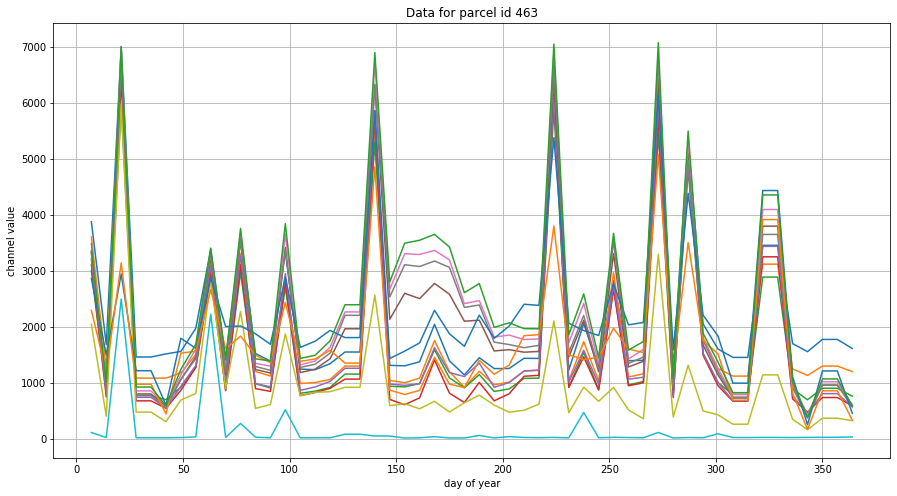

In [11]:
example_row_np = example_row.to_numpy()
example_row_np = np.stack(example_row_np, axis=0)

plt.rcParams['figure.figsize'] = [15, 8]
plt.plot(common_days, example_row_np)
# plt.legend(bands)
plt.style.use('_classic_test_patch')
plt.xlabel('day of year')
plt.ylabel('channel value')
plt.title(f'Data for parcel id {parcel_ID}')
plt.grid()

#### Load geojson

In [12]:
def load_geometry_dict_by_parcelid_all(region_names):
    geometry_dict_by_parcelid_all = {}
    for region_name in tqdm(region_names):
        region_name = region_name.strip('/')
        GEO_JSON_FILE_PATH = os.path.join(ROOT_DATA_PATH, f'GeoJSONs_regional_split/train/AT/demo_eurocrops_{region_name}.geojson')    

        with open(GEO_JSON_FILE_PATH, 'r') as file:
            geojson_data = json.load(file)

        geometry_dict_by_parcelid = {feature['properties']['recno']: feature['geometry'] 
                                     for feature in geojson_data['features']}
        geometry_dict_by_parcelid_all.update(geometry_dict_by_parcelid)
    return geometry_dict_by_parcelid_all


geometry_dict_by_parcelid_all = load_geometry_dict_by_parcelid_all(region_names=region_names)


100%|███████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.28s/it]


In [13]:
geometry_dict_by_parcelid_all[parcel_ID]

{'type': 'MultiPolygon',
 'coordinates': [[[[16.423795460623445, 47.82078105997216],
    [16.423021541535473, 47.82090602658277],
    [16.426825139832076, 47.82334122371044],
    [16.42726926945361, 47.82300513488749],
    [16.423795460623445, 47.82078105997216]]]]}

### Check crop types in the current dataset

In [14]:
def get_crop_types_counts_and_ids(df_data_all, df_labels_all):
    crop_types_counts = {}
    crop_types_ids = {}

    regions_id_set = set(df_data_all.index)
    
    for i, region_id in enumerate(df_labels_all.index):
        if region_id not in regions_id_set:
            continue

        crop_name = df_labels_all.iloc[i]['crpgrpn']
        current_count = crop_types_counts.get(crop_name, 0) 
        crop_types_counts[crop_name] = current_count + 1

        if crop_name not in crop_types_ids:
            crop_types_ids[crop_name] = []
        crop_types_ids[crop_name].append(region_id)
    
    return crop_types_counts, crop_types_ids


        
crop_types_counts, crop_types_ids = get_crop_types_counts_and_ids(df_data_all=df_data_all, df_labels_all=df_labels_all)

print(f'Total crop fields: {sum(crop_types_counts.values())}')
crop_types_counts = {k: v for k, v in sorted(crop_types_counts.items(), key=lambda item: -item[1])}
crop_types_counts

Total crop fields: 94051


{'pasture_meadow': 44061,
 'others': 11708,
 'grain_maize': 10149,
 'winter_common_wheat_and_spelt': 7961,
 'other_plants_harvested_green': 4356,
 'winter_barley': 3152,
 'vineyards': 2456,
 'soya': 1426,
 'sugar_beet': 1046,
 'winter_triticale': 1008,
 'winter_rye': 716,
 'leguminous_plants': 706,
 'sunflower_and_yellow_bloomer': 632,
 'other_cereals_for_the_production_of_grain': 602,
 'millet': 483,
 'winter_rape': 397,
 'fresh_vegetables_melons_and_strawberries': 396,
 'summer_barley': 382,
 'fruit_of_temperate_climate_zones': 369,
 'potatoes': 328,
 'summer_oats': 305,
 'fallow_land_not_crop': 213,
 'cucurbits': 180,
 'other_dry_pulses': 160,
 'summer_durum_wheat': 115,
 'arable_land_seed_and_seedlings': 96,
 'winter_durum_wheat': 95,
 'aromatic_plants_medicinal_and_culinary_plants': 80,
 'energy_crops': 65,
 'summer_common_wheat_and_spelt': 55,
 'not_known': 50,
 'temporary_grass': 49,
 'other_oil_seed_crops': 44,
 'hemp': 36,
 'nuts': 32,
 'flowers_and_ornamental_plants': 31,
 'b

In [15]:
len(df_labels_all), len(df_data_all), len(geometry_dict_by_parcelid_all)

(94051, 94051, 95626)

In [16]:
selected_crop_names = [
#     'nuts',  # 'millet'
    'sugar_beet',
#     'hemp',
    'sunflower_and_yellow_bloomer',
    #'soya',
    'millet',
    #'grain_maize',
    #'pasture_meadow',
]



def get_data_for_crop_type(crop_name):
    data = np.zeros(shape=(len(crop_types_ids[crop_name]), len(common_days), NUMBER_OF_CHANNELS), dtype=float)
    for i, region_id in enumerate(crop_types_ids[crop_name]):
        region_data = df_data_all.loc[region_id].to_numpy()
        data[i, ...] = np.stack(region_data)
    return data
    
    
selected_crops_data = [get_data_for_crop_type(crop_name) for crop_name in selected_crop_names]

In [17]:
print(f'{selected_crops_data[0].shape} = [fields (for the crop type), time (common_days), channels (bands B0-B12)]')

(1046, 52, 13) = [fields (for the crop type), time (common_days), channels (bands B0-B12)]


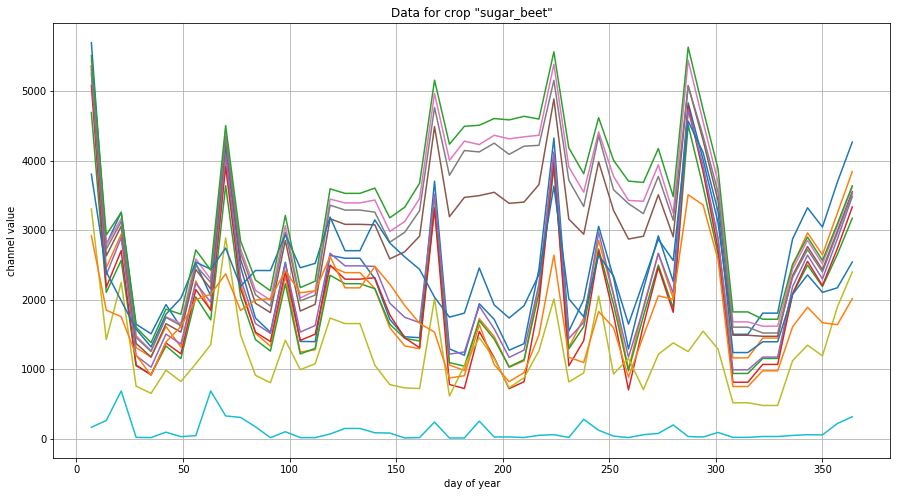

In [18]:
crop_index = 0

data_crop_x = selected_crops_data[crop_index]
data_crop_x_mean = np.mean(data_crop_x, axis=0)
data_crop_x_std = np.std(data_crop_x, axis=0)


plt.rcParams['figure.figsize'] = [15, 8]
plt.plot(common_days, data_crop_x_mean)
# plt.legend(bands)
plt.style.use('_classic_test_patch')
plt.xlabel('day of year')
plt.ylabel('channel value')
plt.title(f'Data for crop "{selected_crop_names[crop_index]}"')
plt.grid()

In [37]:
@dataclass
class CropNdviData:
    mean: np.ndarray
    std: np.ndarray

        
def calc_ndvi(B4, B8):
    return (B8 - B4) / (B8 + B4)
        
    
def get_ndvi_data(data_crop) -> CropNdviData:
    """
    data_crop: [fields (for the crop), time (common_days), channels (bands B0-B12)]')
    return: mean and std for ndvi "channel"
    """
    
    # B8-B4 / (B8+B4)   ( counting from B1 to B13)
    B4 = data_crop[:, :, 4-1]
    B8 = data_crop[:, :, 8-1]

    data_crop_ndvi = calc_ndvi(B4, B8)
    data_crop_mean_ndvi = np.mean(data_crop_ndvi, axis=0)
    data_crop_std_ndvi = np.std(data_crop_ndvi, axis=0) 
    
    return CropNdviData(mean=data_crop_mean_ndvi, std=data_crop_std_ndvi)
    

In [20]:
selected_crops_ndvi_data = [get_ndvi_data(crop_data) for crop_data in selected_crops_data]



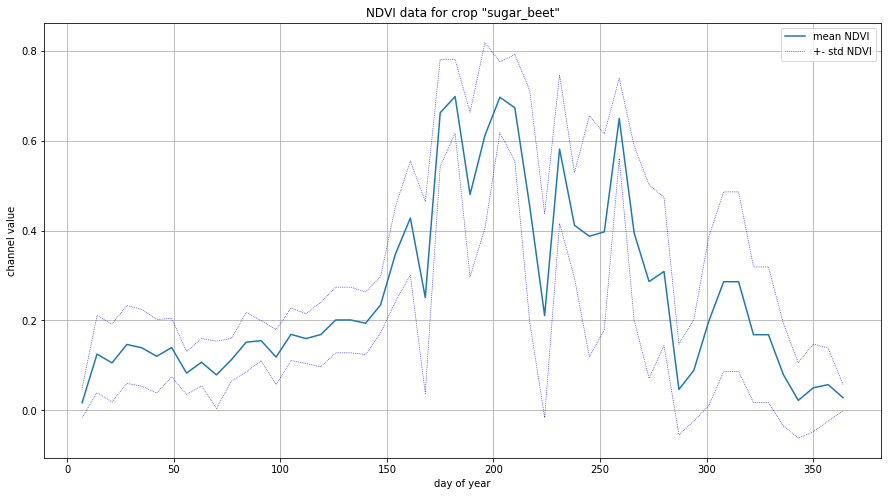

In [21]:
crop_index = 0

data_crop_x_mean_ndvi = selected_crops_ndvi_data[crop_index].mean
data_crop_x_std_ndvi = selected_crops_ndvi_data[crop_index].std


plt.rcParams['figure.figsize'] = [15, 8]
plt.plot(common_days, data_crop_x_mean_ndvi)
plt.plot(common_days, data_crop_x_mean_ndvi - data_crop_x_std_ndvi, ':', color='b', linewidth=0.7)
plt.plot(common_days, data_crop_x_mean_ndvi + data_crop_x_std_ndvi, ':', color='b', linewidth=0.7)

# plt.legend(bands)
plt.style.use('_classic_test_patch')
plt.xlabel('day of year')
plt.ylabel('channel value')
plt.title(f'NDVI data for crop "{selected_crop_names[crop_index]}"')
plt.grid()
plt.legend(['mean NDVI', '+- std NDVI'])

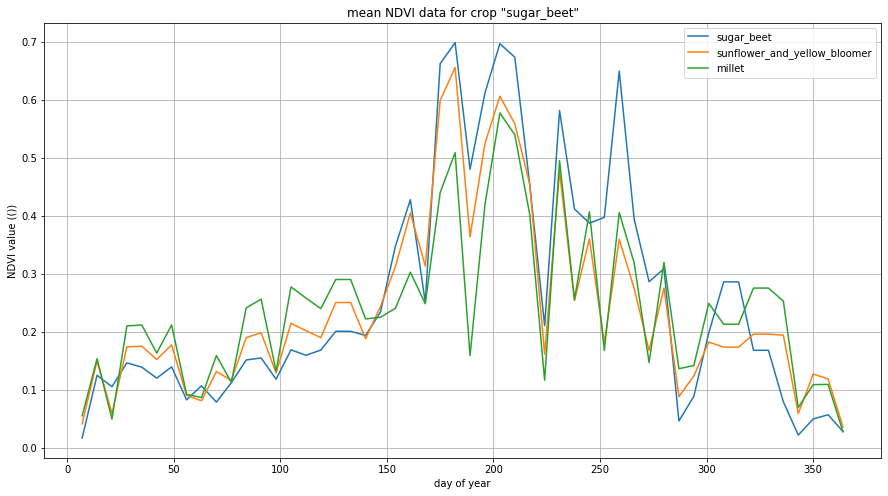

In [22]:
plt.rcParams['figure.figsize'] = [15, 8]

for crop_ndvi_data in selected_crops_ndvi_data:
    plt.plot(common_days, crop_ndvi_data.mean)

# plt.legend(bands)
plt.style.use('_classic_test_patch')
plt.xlabel('day of year')
plt.ylabel('NDVI value (())')
plt.title(f'mean NDVI data for crop "{selected_crop_names[crop_index]}"')
plt.grid()
plt.legend(selected_crop_names)

In [23]:
len(df_data_all)

94051

In [39]:

ndvi.shape

(52,)

### Flatten the data and labels

In [40]:
data_flatten_list = []  
data_flatten_ndvi_list = []


for index, row in df_data_all.iterrows():
    region_data = row.to_numpy()
    region_data_stacked = np.stack(region_data)
    region_data_stacked_flat = region_data_stacked.flatten('F')  # so the first channel through time is continous
    data_flatten_list.append(region_data_stacked_flat)

    B4 = region_data_stacked[:, 4-1]
    B8 = region_data_stacked[:, 8-1]
    region_data_ndvi = calc_ndvi(B4, B8)
    data_flatten_ndvi_list.append(region_data_ndvi)
    
data_flatten = np.stack(data_flatten_list)
data_ndvi_flatten = np.stack(data_flatten_ndvi_list)

In [41]:
data_flatten.shape, data_ndvi_flatten.shape

((94051, 676), (94051, 52))

In [45]:
df_labels_all

set(df_labels_all)

,crpgrpc,crpgrpn
recno,,
463,33111022,leguminous_plants
464,33111022,leguminous_plants
504,33111022,leguminous_plants
577,33111022,leguminous_plants
578,33111022,leguminous_plants


In [76]:
all_crop_types = set(df_labels_all.iloc[:, 1].to_numpy())
all_crop_types_map = {name: i for i, name in enumerate(all_crop_types)}
print(str(all_crop_types_map)[:90] + '...')

data_flatten_labels_list = [all_crop_types_map[name] for name in df_labels_all.iloc[:, 1].to_numpy()]
data_flatten_labels = np.array(data_flatten_labels_list)
print(data_flatten_labels)

{'nuts': 0, 'other_oil_seed_crops': 1, 'temporary_grass': 2, 'fallow_land_not_crop': 3, 'o...
[17 17 17 ... 12 12 12]


In [198]:
# crops_to_use__names = [
#     #'pasture_meadow',
#     'grain_maize',
#     #'winter_common_wheat_and_spelt',
#     #'other_plants_harvested_green',
#     'winter_barley',
#     'vineyards',
#     'soya',
#     'sugar_beet',
#     'winter_triticale',
#     'winter_rye',
#     'leguminous_plants',
#     'sunflower_and_yellow_bloomer',
#     #'other_cereals_for_the_production_of_grain',
#     'millet',
#     'winter_rape',
#     #'fresh_vegetables_melons_and_strawberries',
#     'summer_barley',
#     #'fruit_of_temperate_climate_zones',
#     'potatoes',
#     'summer_oats',
#     'cucurbits',
#     #'other_dry_pulses',
#     'summer_durum_wheat',
#     #'arable_land_seed_and_seedlings',
#     'winter_durum_wheat',
#     #'aromatic_plants_medicinal_and_culinary_plants',
#     #'energy_crops',
#     #'summer_common_wheat_and_spelt',
#     #'temporary_grass',
#     #'other_oil_seed_crops',
#     'hemp',
#     'nuts',
#     #'flowers_and_ornamental_plants',
#     #'berry_species',
#     #'nurseries',
# ]
crops_to_use__names = [ 
    'sunflower_and_yellow_bloomer',
    'nuts',
    'soya',
    'vineyards',
]

crops_to_use = [all_crop_types_map[name] for name in crops_to_use__names]

In [199]:
indexes_to_use = []
for i in range(len(df_labels_all)):
    label = data_flatten_labels[i]
    if label not in crops_to_use:
        continue  # skip this data, not interested
    indexes_to_use.append(i)
# indexes_to_use = np.array(indexes_to_use)

selected_data_flatten_labels = np.take(data_flatten_labels, indexes_to_use)
selected_data_flatten = data_flatten[indexes_to_use, :]
selected_data_ndvi_flatten = data_ndvi_flatten[indexes_to_use, :]

In [200]:
selected_data_flatten_labels.shape, selected_data_flatten.shape, selected_data_ndvi_flatten.shape

((4546,), (4546, 676), (4546, 52))

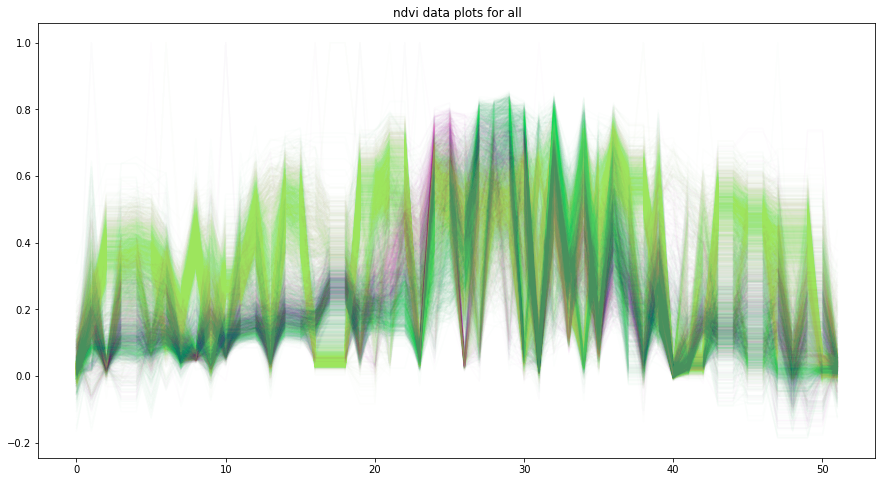

In [201]:
x = selected_data_ndvi_flatten[:10000, :]
colors = [
    (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1), 0.01) 
    for _ in range(max(selected_data_flatten_labels) + 1)]


plt.rcParams['figure.figsize'] = [15, 8]
plt.title('ndvi data plots for all')
for i, row in enumerate(x):
    label = selected_data_flatten_labels[i]
    if label > 55:
        continue
    plt.plot(row, color=colors[label])


In [202]:
data_ndvi_flatten[[1,2,3,], :].shape

(3, 52)

/home/przemek/Projects/pp/eurocrops/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/przemek/Projects/pp/eurocrops/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4546 samples in 0.000s...
[t-SNE] Computed neighbors for 4546 samples in 0.425s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4546
[t-SNE] Computed conditional probabilities for sample 2000 / 4546
[t-SNE] Computed conditional probabilities for sample 3000 / 4546
[t-SNE] Computed conditional probabilities for sample 4000 / 4546
[t-SNE] Computed conditional probabilities for sample 4546 / 4546
[t-SNE] Mean sigma: 0.261939
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.059372
[t-SNE] KL divergence after 1000 iterations: 1.117985


[Text(0.5, 1.0, 'selected_data_flatten_labels crops')]

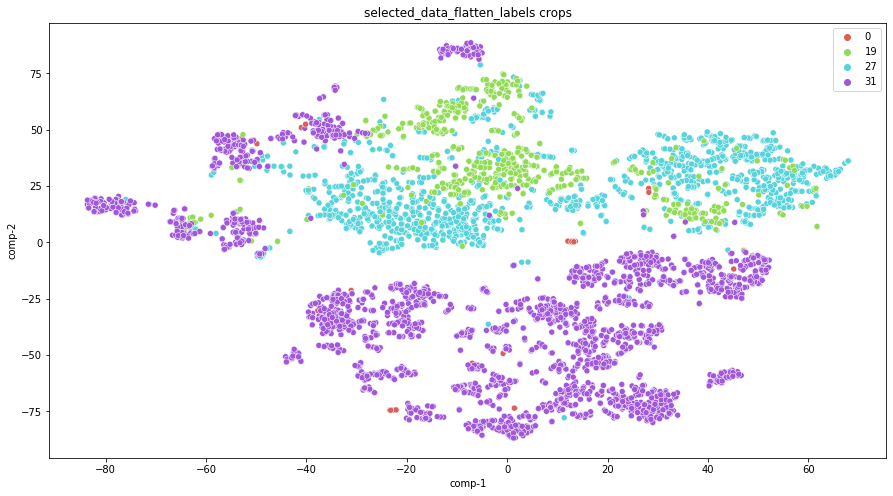

In [205]:
import seaborn as sns
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(selected_data_ndvi_flatten)

df = pd.DataFrame()
df["y"] = selected_data_flatten_labels
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", len(set(selected_data_flatten_labels))),
                data=df).set(title="selected_data_flatten_labels crops")

In [209]:
# remap output classes to consecutive values

In [224]:
selected_data_flatten_labels_mapping = {value: i for i, value in enumerate(set(selected_data_flatten_labels))}


selected_data_flatten_labels_mapped = copy.copy(selected_data_flatten_labels)
for i in range(len(selected_data_flatten_labels_mapped)):
    selected_data_flatten_labels_mapped[i] = selected_data_flatten_labels_mapping[selected_data_flatten_labels_mapped[i]]

In [287]:
x = selected_data_ndvi_flatten
y = selected_data_flatten_labels_mapped
NUMBER_OF_CLASSES = len(set(y))


def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

n = int(len(y) * 0.9)
x_shuffled, y_shuffled = unison_shuffled_copies(x, y)
x_train, x_test = x_shuffled[:n], x_shuffled[n:]
y_train, y_test = y_shuffled[:n], y_shuffled[n:]

len(x_train), len(x_test)

(4091, 455)

In [288]:
from sklearn import svm

clf = svm.SVC()
clf.fit(x_train, y_train)

y_predicted = clf.predict(x_test)

predicted_correctly = np.count_nonzero(y_predicted == y_test)
predicted_correctly, len(y_predicted)

(433, 455)

In [255]:
NUMBER_OF_INPUTS = x[0].shape[0]
print(f'NUMBER_OF_INPUTS = {NUMBER_OF_INPUTS}, NUMBER_OF_CLASSES={NUMBER_OF_CLASSES}')


NUMBER_OF_INPUTS = 52, NUMBER_OF_CLASSES=4


In [259]:
model = nn.Sequential(
    nn.Linear(in_features=NUMBER_OF_INPUTS, out_features=200),
    #nn.BatchNorm1d(num_features=200),
    nn.ReLU(),

    nn.Linear(in_features=200, out_features=100),
    #nn.BatchNorm1d(num_features=100),
    nn.ReLU(),

    nn.Linear(in_features=100, out_features=50),
    #nn.BatchNorm1d(num_features=50),
    nn.ReLU(),

    nn.Dropout(0.1),
    nn.Linear(in_features=50, out_features=NUMBER_OF_CLASSES),
    nn.Softmax(),
)

In [241]:
todo how much better than random guessing
calss weight for nn
